In [1]:
import feyn
import pandas as pd
from feyn.plots import plot_regression
from feyn.tools import split
from sklearn.metrics import mean_absolute_error

from feyn.plots.interactive import interactive_activation_flow


This version of Feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at https://abzu.ai/eula.

In [2]:
df = pd.read_csv("/Users/admin/Downloads/parklane_edited.csv", index_col='timestamp')

In [3]:
# filter where hr or hb is  not 0
df = df[(df['sys_hr'] != 0) | (df['sys_hb'] != 0)]
df = df[(df['h_chwst'] >=5) & (df['h_chwst'] <=20)]
df = df[(df['h_chwrt'] >=5) & (df['h_chwrt'] <=25)]
df = df[(df['pchwp_1_kw'] >=0) & (df['pchwp_1_kw'] <=25)]
#df = df[(df['pchwp_2_kw'] >=0) & (df['pchwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >= 0) & (df['h_chwf'] <= 1500)]
df = df[(df['cwp_1_kw'] >= 0) & (df['cwp_1_kw'] <=25)]
df = df[(df['cwp_2_kw'] >= 0) & (df['cwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >=0) & (df['h_chwf'] <=1500)]
df = df[(df['h_cwst']>=20) & (df['h_cwst']<=32)]
df = df[(df['h_cwrt']>=20) & (df['h_cwrt']<=40)]
df = df[(df['ch_1_kwe']>=0) & (df['ch_1_kwe']<=350)]
df = df[(df['ch_2_kwe']>=0) & (df['ch_2_kwe']<=350)]
df = df[(df['ct_1_kw']>=0) & (df['ct_1_kw']<=15)]
df = df[(df['ct_2_kw']>=0) & (df['ct_2_kw']<=15)]
df = df[(df['sys_cl']>=0) & (df['sys_cl']<=600)]
df = df[(df['sys_hr']>=0) & (df['sys_hr']<=1000)]
df = df[(df['sys_kw']>=0) & (df['sys_kw']<=400)]
fil_df = df[(df['ch_sysef']>=0.3) & (df['ch_sysef']<=0.8)]

# replace NaN values with 0? median imputation
fil_df = fil_df.fillna(fil_df.median())

# creating Lift Column, Lift: [h_cwrt-h_chwst]
fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
# combining total power input of both chillers
fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']


/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_8114/1696555676.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_8114/1696555676.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']


In [4]:
ch_sysef_df = fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw']]

ch_sysef_df.head(5)

,ch_sysef,lift,sys_cl,ct_tot_kw
timestamp,,,,
12/3/23 10:35,0.387167,7.367701,127.538132,3.508719
12/3/23 10:36,0.308619,7.805637,152.515945,3.477781
12/3/23 10:37,0.391576,8.073826,126.885735,7.184000
12/3/23 10:38,0.550531,8.440350,107.953125,7.088001
12/3/23 10:39,0.467190,9.664524,155.478806,7.152000


<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="352.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 755 352.0" width="755" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="275.0" width="471" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="110.0"><title>ch_sysef
linear:
scale=0.247948
scale offset=0.000000
w=0.831844
bias=2.4041</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="131.5">ch_sysef</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="119.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="119.0">out</text><line stroke="#1E1E1E" x1="331" x2="361" y1="127.5" y2="127.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="110.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="131.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="119.0">1</text><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="118.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="157.5" y2="136.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>gaussian</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">2</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>sys_cl
linear:
scale=0.003529
scale offset=329.851353
w=-1.800048
bias=-0.2091</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">sys_cl</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>lift
linear:
scale=0.082215
scale offset=23.603280
w=-0.323166
bias=0.3208</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">lift</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="140.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="161.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="149.0">5</text><line stroke="#1E1E1E" x1="91" x2="121" y1="157.5" y2="148.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="217.5" y2="166.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="140.0"><title>lift
linear
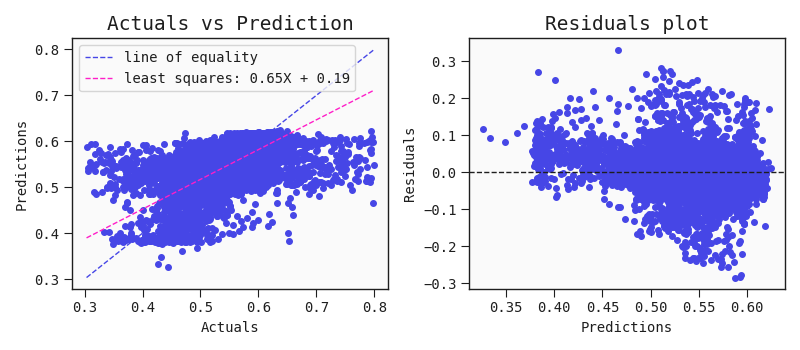
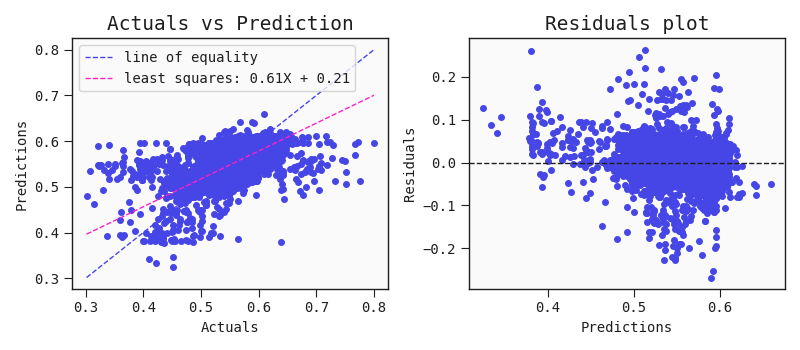

In [5]:
train, test = split(ch_sysef_df, ratio=[0.8, 0.2], random_state=42)

ql = feyn.QLattice(random_seed=42)

models = ql.sample_models(train.columns, 'ch_sysef', max_complexity=15)

models = feyn.fit_models(models, train, 'absolute_error', 'bic')

models = feyn.prune_models(models)

models = feyn.get_diverse_models(
    models=models,
    n=10
)

best = models[0]
best.plot(
    data=train,
    compare_data=test
)


In [6]:
mean_absolute_error(test['ch_sysef'], best.predict(test)) * 100

1.8898470840693622

In [7]:
best.predict(test)

array([0.58193526, 0.58478374, 0.54265387, ..., 0.54187409, 0.54180766,
       0.5422618 ])

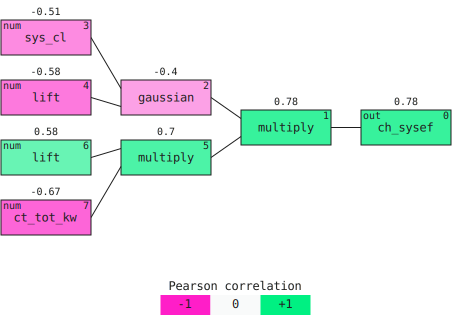

In [8]:
best.plot_signal(train)

In [9]:
interactive_activation_flow(best, train)

interactive(children=(FloatSlider(value=311.945739, description='sys_cl', max=595.329163, min=28.562315), Floa…

<function feyn.plots.interactive._graph_flow.interactive_activation_flow.<locals>.flow(**kwargs)>

In [16]:
train, test = split(fil_df, ratio=[0.8, 0.2], random_state=42)

ql = feyn.QLattice(random_seed=42)

models = ql.sample_models(train.columns, 'ch_sysef', max_complexity=100)

models = feyn.fit_models(models, train, 'absolute_error', 'bic')

models = feyn.prune_models(models)

models = feyn.get_diverse_models(
    models=models,
    n=100
)

best_ovrl = models[0]
best_ovrl.plot(
    data=train,
    compare_data=test
)

In [ ]:
mean_absolute_error(test['ch_sysef'], best_ovrl.predict(test)) * 100

1.9426483815948474